In [0]:
import pandas as pd
from matplotlib.backend_bases import MouseButton
import matplotlib.pyplot as plt
import numpy as np
import random as r
import time

import heapq


In [0]:
MAX_VALUE = 100000

class Map():
  def __init__(self, grid_size, obstacle_rate, sqr_size= 10, debugging = False, obstacles = [13,7,5,3,1]):
    self.grid_size = grid_size
    self.sqr_size = sqr_size
    self.obstacle_rate = obstacle_rate
    img = np.ones((grid_size*sqr_size+1,grid_size*sqr_size+1,3))
    for i in range(grid_size*sqr_size+1):
      img[0,i] = 0
      img[i,0] = 0
      img[-1,i] = 0
      img[i,-1] = 0

    for i in range(grid_size-1):
      for j in range(grid_size*sqr_size+1):
        img[(i+1)*sqr_size, j]=0
        img[j, (i+1)*sqr_size]=0

    img = img*255
    img = img.astype(int)
    self.img = img
    grid = np.ones((grid_size, grid_size))
    grid = grid*MAX_VALUE
    grid = grid.astype(int)
    self.grid = grid

    self.__obstacle_color = (50,50,50)
    self.__start_color = (200,0,0)
    self.__goal_color = (0,250,0)
    self.__path_color = (0,250,250)
    self.__cell_testing_color = (70,70,250)
    self.__cell_tested_color = (140,140,255)
    self.start_pos = (0,0)
    self.goal_pos = (grid_size-1,grid_size-1)
    self.__debugging = debugging
    self.tested = []
    self.testing = []
    self.path_to_goal = []
    self.show_img_after = 10
    self.show_img_Astar = 3
    self.obstacles = np.array(obstacles)
    self.set_obstacles()
    self.set_rand_positions()

  # Sets the start and goal positions randomly 
  def set_rand_positions(self):
    idx = r.randrange(self.grid_size)
    idy = r.randrange(self.grid_size)
    while(self.grid[idx, idy]==-1):
      idx = r.randrange(self.grid_size)
      idy = r.randrange(self.grid_size)
    self.set_start_position((idx, idy))

    idx = r.randrange(self.grid_size)
    idy = r.randrange(self.grid_size)
    while(self.grid[idx, idy]==-1 and (idx,idy)!=self.start_pos):
      idx = r.randrange(self.grid_size)
      idy = r.randrange(self.grid_size)
    self.set_goal_position((idx, idy))

  # Changes the color of a cell
  def color_square(self, idx,idy, color):
    for i in range(self.sqr_size-1):
      for j in range(self.sqr_size-1):
        self.img[idx*self.sqr_size+i+1, idy*self.sqr_size+j+1] = color

  # Sets the obstacles using random distribution
  def set_obstacles(self):
    obstacles = (self.obstacles*self.obstacle_rate).astype(int)
    for i in range(len(obstacles)):
      for k in range(obstacles[i]):
        obs_len = i+1
        place_found = False
        while(not place_found):
          place_found = True
          obs_dir = r.randrange(2)
          flag = True
          if obs_dir==0:
            idx = r.randrange(self.grid_size-obs_len+1)
            idy = r.randrange(self.grid_size)
            for j in range(obs_len):
              if(self.grid[idx+j, idy]==-1):
                place_found = False
                break
          else:
            idy = r.randrange(self.grid_size-obs_len+1)
            idx = r.randrange(self.grid_size)
            for j in range(obs_len):
              if(self.grid[idx, idy+j]==-1):
                place_found = False
                break

        for j in range(obs_len):
          self.grid[idx + (1-obs_dir)*j, idy + obs_dir*j]=-1
          self.color_square(idx + (1-obs_dir)*j, idy + obs_dir*j, self.__obstacle_color)

  # Initializes the values of the grid array
  def init_grid(self):
    for i in range(self.grid_size):
      for j in range(self.grid_size):
        if(self.grid[i,j]>-1):
          self.grid[i,j]=MAX_VALUE
          self.color_square(i,j, (255,255,255))
        if (i,j)==self.start_pos:
          self.color_square(i,j, self.__start_color)
        if (i,j)==self.goal_pos:
          self.color_square(i,j, self.__goal_color)

    self.set_goal_position(self.goal_pos)


  # Initializes all parameters for the path finding algorithm
  def init_for_algo(self, algo="Dijkstra"):
    self.tested = []
    self.testing = []
    self.path_to_goal = []
    self.init_grid()
    if algo =="Potential":
      self.grid[self.start_pos[0],self.start_pos[1]]=MAX_VALUE
      self.grid[self.goal_pos[0],self.goal_pos[1]]=0
    else:
      self.grid[self.start_pos[0],self.start_pos[1]]=0



  # Sets the position of the Start point
  def set_start_position(self, pos):
    if self.grid[self.start_pos[0], self.start_pos[1]]>-1:
      self.grid[self.start_pos[0], self.start_pos[1]]= MAX_VALUE   # reset the old start position
    self.start_pos = pos
    self.grid[pos[0], pos[1]]=0
    self.color_square(pos[0], pos[1], self.__start_color)

  # Sets the position of the Goal point
  def set_goal_position(self, pos):
    self.goal_pos = pos
    self.color_square(pos[0], pos[1], self.__goal_color)

  # Shows a new image
  def show(self):
    fig, ax =plt.subplots(1,1, figsize=(10,10))
    ax.axis('off')
    ax.imshow(self.img) 
    plt.show()

  def update(self):
    pass
  
  def get_adjacent(self, pos):
    idx = pos[0]
    idy = pos[1]
    adj = []
    if idx>0:
      adj.append((idx-1,idy))
    if idy>0:
      adj.append((idx,idy-1))
    if idx<self.grid_size-1:
      adj.append((idx+1,idy))
    if idy<self.grid_size-1:
      adj.append((idx,idy+1))
    return adj

    
  def add_text(self):
    #TODO
    #add text to picture
    pass

  def add_to_testing(self, pos):
    if self.__debugging:
      print("adding to testing array:", pos)
    self.testing.append(pos)
    self.color_square(pos[0],pos[1], self.__cell_testing_color)

  def add_to_tested(self, pos):
    if self.__debugging:
      print("adding to tested array:", pos)
    self.tested.append(pos)
    self.color_square(pos[0],pos[1], self.__cell_tested_color)

  def add_to_path(self, pos):
    if self.__debugging:
      print("adding to path array:", pos)
    self.path_to_goal.append(pos)

    self.color_square(pos[0],pos[1], self.__path_color)

  def set_debugging_mode(self, debugging_mode):
    self.__debugging = debugging_mode




 # Dijkstra Algorithm:
  def dijkstra(self):
    show_count = 0
    current_pos = self.start_pos
    goal_reached = False

    self.init_for_algo(algo="Dijkstra")
   
    #------------
    if self.__debugging:
      print("cur_pos: ",current_pos)
      
    #------------ 
    if current_pos == self.goal_pos:
      goal_reached = True
    adj = self.get_adjacent(current_pos)
    #------------
    if self.__debugging:
      print("adj array: ",adj)
    #------------
    # creating the unvisited list
    unvisited = []

    # adding the avilable neighbors to the unvisited list
    for cell in adj:
      if self.grid[cell[0], cell[1]]> self.grid[current_pos[0], current_pos[1]]+1:
        if cell not in self.tested and cell not in self.testing:
          self.grid[cell[0], cell[1]] = self.grid[current_pos[0], current_pos[1]]+1
          heapq.heappush(unvisited, ( self.grid[current_pos[0], current_pos[1]]+1 ,cell))
          self.add_to_testing(cell)

          #------------
          if self.__debugging:
            print("adding new cell to unvisited: ",cell)
          #------------

    while(len(unvisited) and (not goal_reached)):
      show_count = show_count+1
      uv = heapq.heappop(unvisited)
      current_pos= uv[1]
      self.add_to_tested(current_pos)
      if current_pos == self.goal_pos:
        goal_reached = True
        self.show()
        break
      
      #------------
      if self.__debugging:
        print("cur_pos: ",current_pos)
        print("unvisited array: ",unvisited)
        print("Testing array: ",self.testing)
      if show_count% self.show_img_after == 0:
        self.show()
      #------------
      
      adj = self.get_adjacent(current_pos)

      # adding the avilable neighbors to the unvisited list
      for cell in adj:
        if self.grid[cell[0], cell[1]]> self.grid[current_pos[0], current_pos[1]]+1:
          if cell not in self.tested and cell not in self.testing:
            self.grid[cell[0], cell[1]] = self.grid[current_pos[0], current_pos[1]]+1
            heapq.heappush(unvisited, ( self.grid[current_pos[0], current_pos[1]]+1 ,cell))
            self.add_to_testing(cell)
            #------------
            if self.__debugging:
              print("adding new cell to unvisited: ",cell)
            #------------
    
    if not goal_reached:
      print("Goal is not reachable.. path finding failed..")
    else:
      path = []
      current_value = self.grid[self.goal_pos[0], self.goal_pos[1]]
      current_pos = self.goal_pos
      while(current_value>0):
        adj = self.get_adjacent(current_pos)
        for cell in adj:
          if self.grid[cell[0], cell[1]] < current_value and self.grid[cell[0], cell[1]] >= 0:
            current_pos = cell
            current_value = self.grid[cell[0], cell[1]]
            self.add_to_path(cell)
            break
      self.set_start_position(self.start_pos)
      self.set_goal_position(self.goal_pos)
    self.show()

  # H function for A* algorithm
  def h_function(self, pos):
    sum_ = 0
    sum_ += abs(self.goal_pos[0] - pos[0])
    sum_ += abs(self.goal_pos[1] - pos[1])
    return sum_


  # A* Algorithm:
  def Astar(self):
    show_count = 0
    current_pos = self.start_pos
    goal_reached = False

    self.init_for_algo(algo="Astar")
    #------------
    if self.__debugging:
      print("cur_pos: ",current_pos)
      
    #------------ 
    if current_pos == self.goal_pos:
      goal_reached = True
    adj = self.get_adjacent(current_pos)
    #------------
    if self.__debugging:
      print("adj array: ",adj)
    #------------
    # creating the unvisited list
    unvisited = []

    # adding the avilable neighbors to the unvisited list
    for cell in adj:
      if self.grid[cell[0], cell[1]]> self.grid[current_pos[0], current_pos[1]]+1:
        if cell not in self.tested and cell not in self.testing:
          self.grid[cell[0], cell[1]] = self.grid[current_pos[0], current_pos[1]]+1
          heapq.heappush(unvisited, ( self.grid[current_pos[0], current_pos[1]]+1 + self.h_function(cell) ,cell))
          self.add_to_testing(cell)

          #------------
          if self.__debugging:
            print("adding new cell to unvisited: ",cell)
          #------------

    while(len(unvisited) and (not goal_reached)):
      show_count = show_count+1
      uv = heapq.heappop(unvisited)
      current_pos= uv[1]
      self.add_to_tested(current_pos)
      if current_pos == self.goal_pos:
        goal_reached = True
        self.show()
        break
      
      #------------
      if self.__debugging:
        print("cur_pos: ",current_pos)
        print("unvisited array: ",unvisited)
        print("Testing array: ",self.testing)
      if show_count% self.show_img_Astar == 0:
        self.show()
      #------------
      
      adj = self.get_adjacent(current_pos)

      # adding the avilable neighbors to the unvisited list
      for cell in adj:
        if self.grid[cell[0], cell[1]]> self.grid[current_pos[0], current_pos[1]]+1:
          if cell not in self.tested and cell not in self.testing:
            self.grid[cell[0], cell[1]] = self.grid[current_pos[0], current_pos[1]]+1
            heapq.heappush(unvisited, ( self.grid[current_pos[0], current_pos[1]]+1 + self.h_function(cell) ,cell))
            self.add_to_testing(cell)
            #------------
            if self.__debugging:
              print("adding new cell to unvisited: ",cell)
            #------------
    
    if not goal_reached:
      print("Goal is not reachable.. path finding failed..")
    else:
      path = []
      current_value = self.grid[self.goal_pos[0], self.goal_pos[1]]
      current_pos = self.goal_pos
      while(current_value>0):
        adj = self.get_adjacent(current_pos)
        for cell in adj:
          if self.grid[cell[0], cell[1]] < current_value and self.grid[cell[0], cell[1]] >= 0:
            current_pos = cell
            current_value = self.grid[cell[0], cell[1]]
            self.add_to_path(cell)
            break
      self.set_start_position(self.start_pos)
      self.set_goal_position(self.goal_pos)
    self.show()


  # Potetial algorithm:
  def potential(self):
    show_count = 0
    current_pos = self.goal_pos    
    goal_reached = False

    self.init_for_algo(algo="Potential")
    #------------
    if self.__debugging:
      print("cur_pos: ",current_pos)
      
    #------------ 
    if current_pos == self.start_pos:
      goal_reached = True
    adj = self.get_adjacent(current_pos)
    #------------
    if self.__debugging:
      print("adj array: ",adj)
    #------------
    # creating the unvisited list
    unvisited = []

    

    # adding the avilable neighbors to the unvisited list
    for cell in adj:
      if self.grid[cell[0], cell[1]]> self.grid[current_pos[0], current_pos[1]]+1 or cell==self.start_pos:
        if cell not in self.tested and cell not in self.testing:
          self.grid[cell[0], cell[1]] = self.grid[current_pos[0], current_pos[1]]+4
          heapq.heappush(unvisited, (self.grid[cell[0], cell[1]] ,cell))
          self.add_to_testing(cell)

          #------------
          if self.__debugging:
            print("adding new cell to unvisited: ",cell)
          #------------
    
    while(len(unvisited) and (not goal_reached)):
      show_count = show_count+1
      uv = heapq.heappop(unvisited)
      current_pos= uv[1]
      self.add_to_tested(current_pos)
      if current_pos == self.start_pos:
        goal_reached = True
        self.show()
        break
      
      #------------
      if self.__debugging:
        print("cur_pos: ",current_pos)
        print("unvisited array: ",unvisited)
        print("Testing array: ",self.testing)
      if show_count% self.show_img_after == 0:
        self.show()
      #------------
      
      adj = self.get_adjacent(current_pos)

      # adding the walls effect to the cost function
      for cell in adj:
        if self.grid[cell[0], cell[1]]== -1:
          self.grid[current_pos[0],current_pos[1]]+= 1
      # adding the avilable neighbors to the unvisited list
      for cell in adj:
        if self.grid[cell[0], cell[1]]> self.grid[current_pos[0], current_pos[1]]:            
          if self.grid[cell[0], cell[1]] > self.grid[current_pos[0], current_pos[1]]+4:
            # always use the minimum value to reach the cell
            self.grid[cell[0], cell[1]] = self.grid[current_pos[0], current_pos[1]]+4
            # if the cell is already tested re test it again
            if cell in self.tested:
              self.tested.remove(cell)
            if not cell in unvisited:
              heapq.heappush(unvisited, ( self.grid[cell[0], cell[1]] ,cell))
              self.add_to_testing(cell)
              #------------
              if self.__debugging:
                print("adding new cell to unvisited: ",cell)
              #------------

    if not goal_reached:
      print("Goal is not reachable.. path finding failed..")
      
    else:
      path = []
      current_value = self.grid[self.start_pos[0], self.start_pos[1]]
      current_pos = self.start_pos
      while(current_value>0):
        adj = self.get_adjacent(current_pos)
        min = current_value
        for cell in adj:
          if self.grid[cell[0], cell[1]] > -1 and self.grid[cell[0], cell[1]] < current_value:
            current_value = self.grid[cell[0], cell[1]]
        for cell in adj:
          if self.grid[cell[0], cell[1]] == current_value:
            current_pos = cell
            current_value = self.grid[cell[0], cell[1]]
            self.add_to_path(cell)
            break
      self.set_start_position(self.start_pos)
      self.set_goal_position(self.goal_pos)
    self.show()


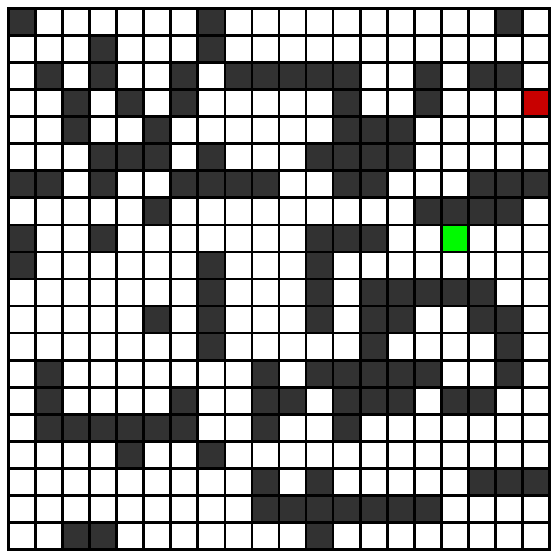

In [0]:
grid_size = 20  # define the size of the map
obstacle_rate = 2   # an coefficient by which the number of obstacles is multiplied 
myMap = Map(grid_size, obstacle_rate)

myMap.show()    # display the map with the START position in RED and GOAL position in GREEN

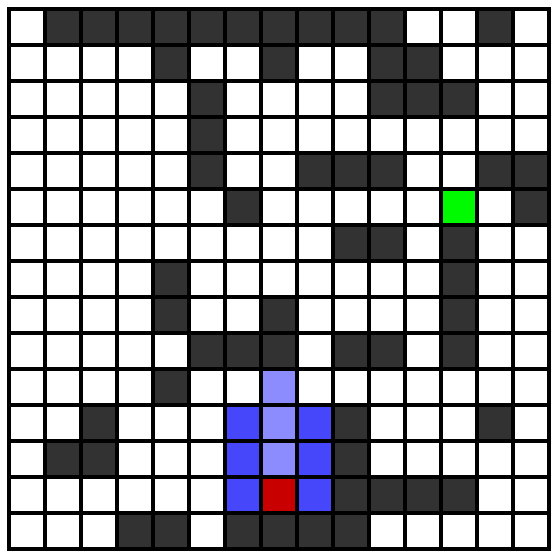

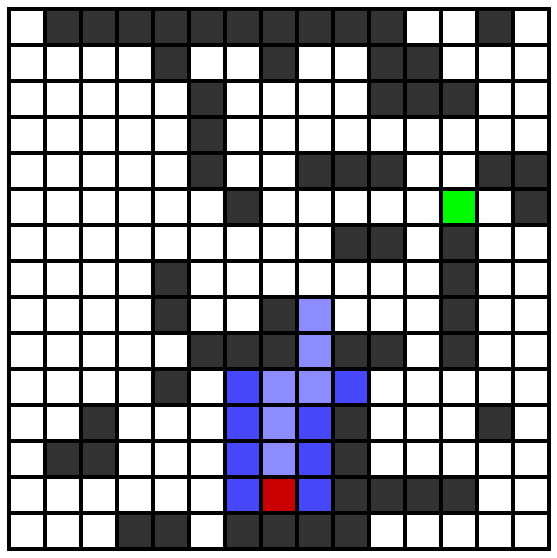

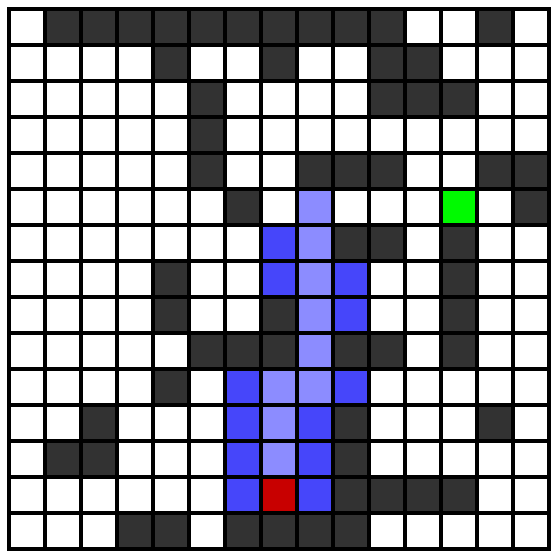

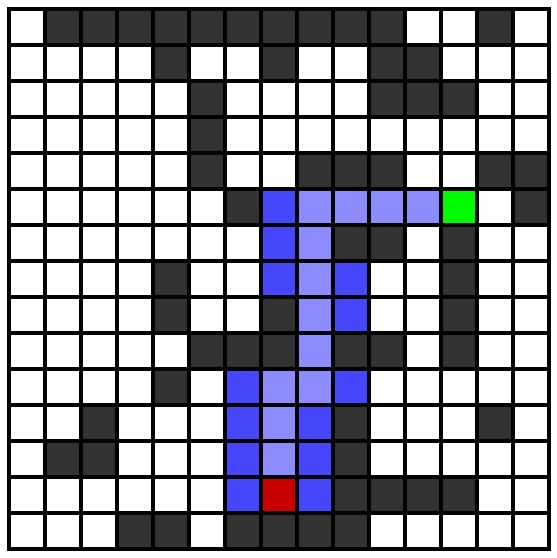

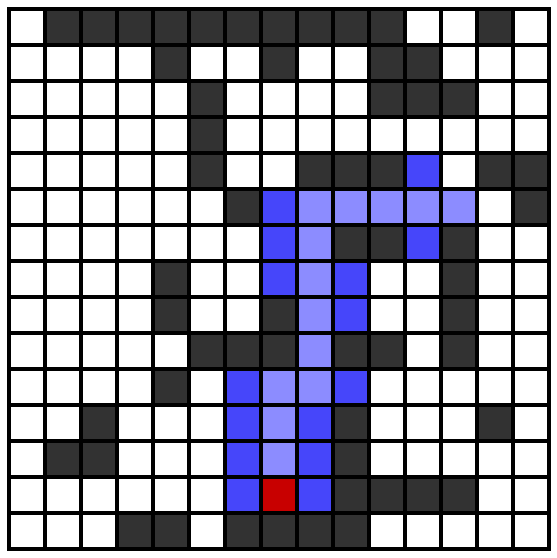

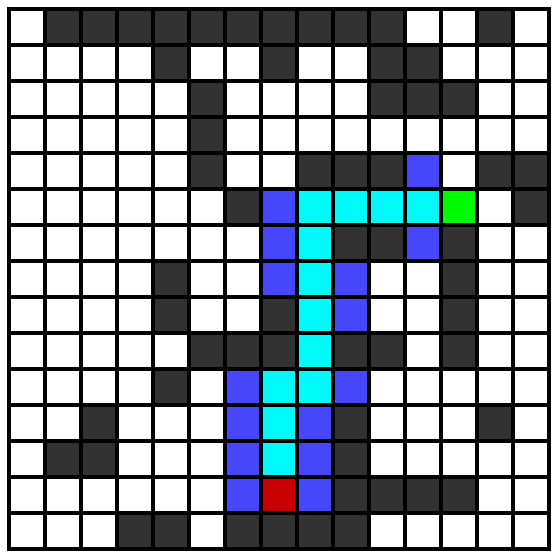

In [0]:
myMap.Astar()   # apply "A*" algorithm

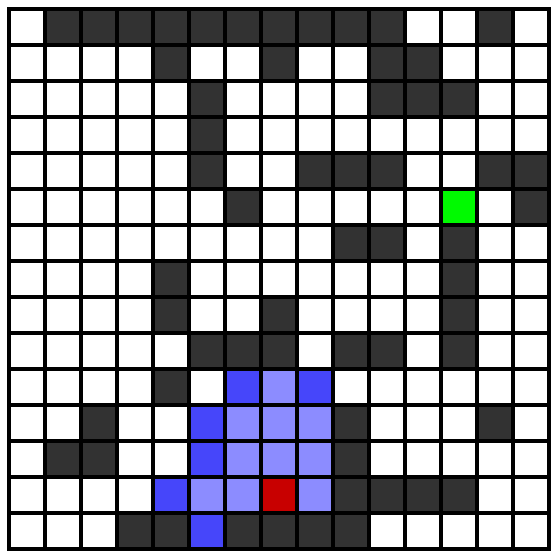

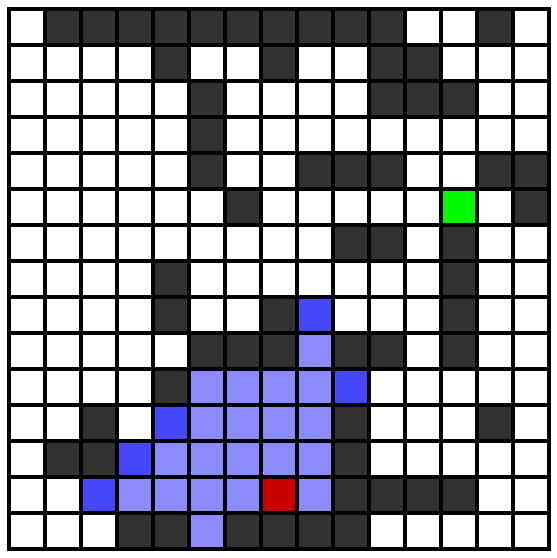

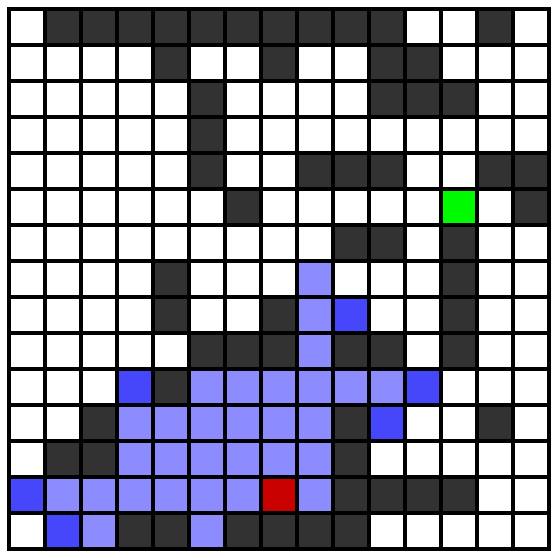

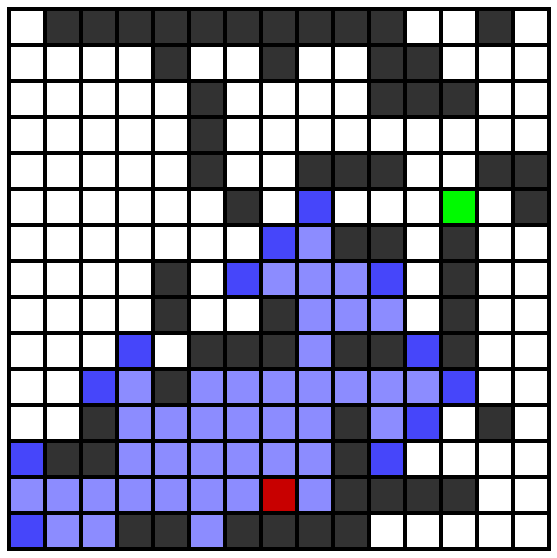

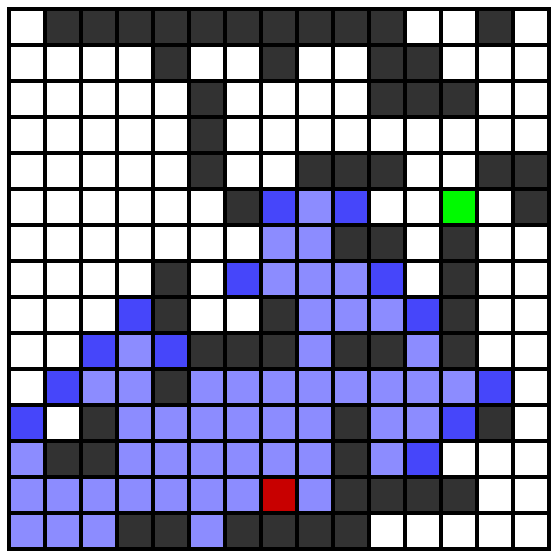

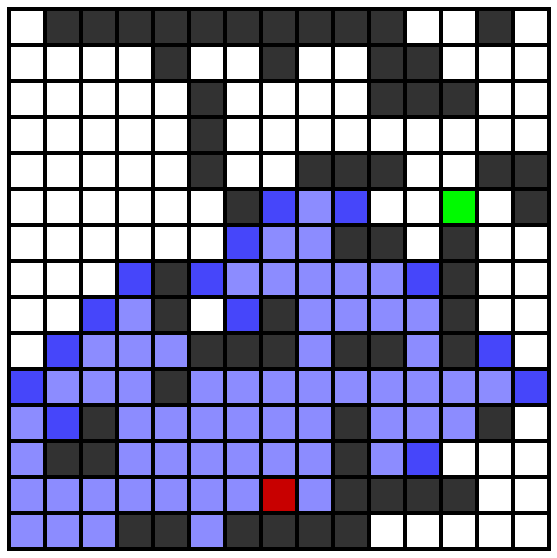

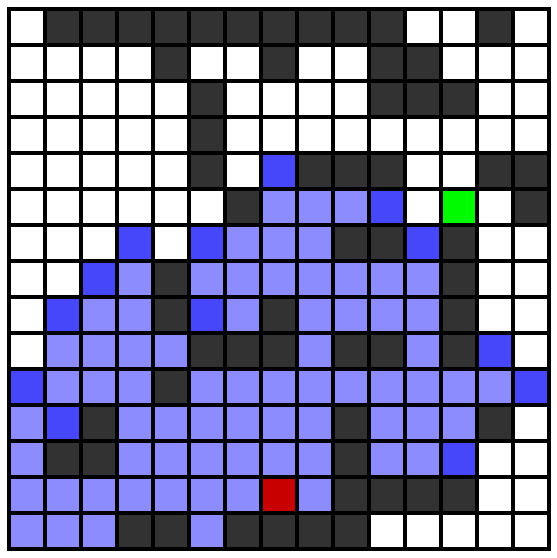

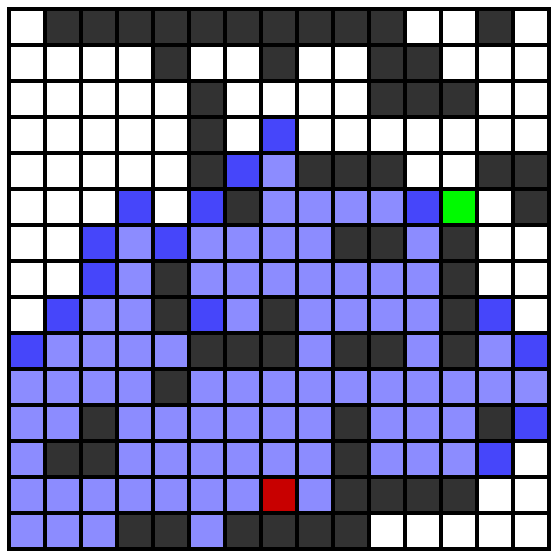

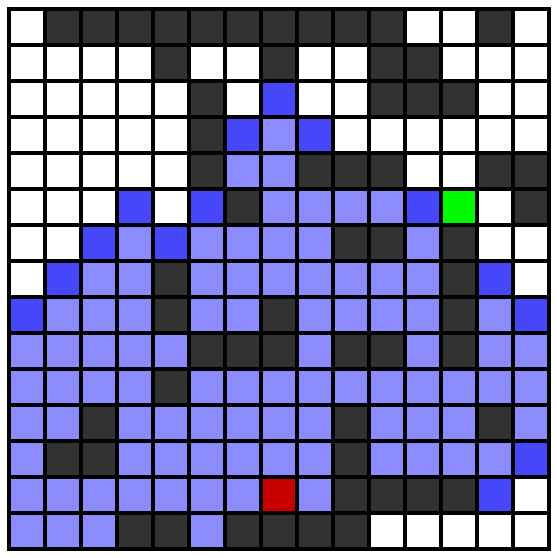

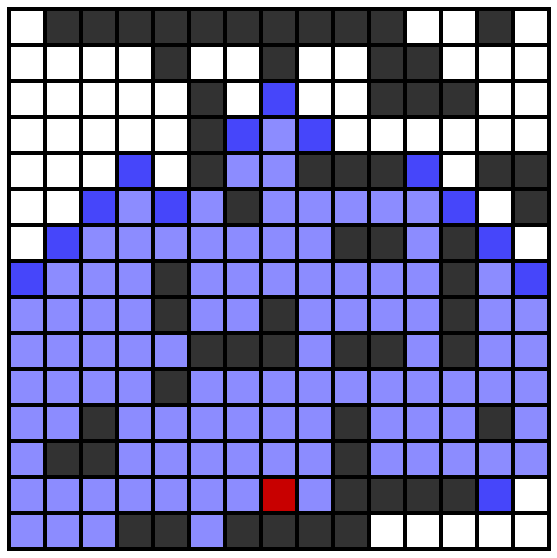

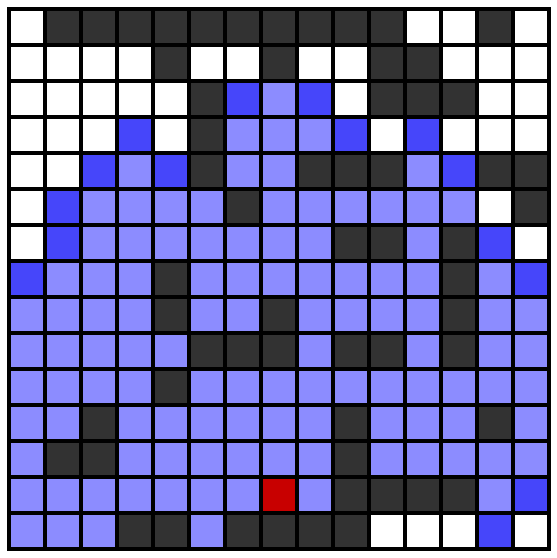

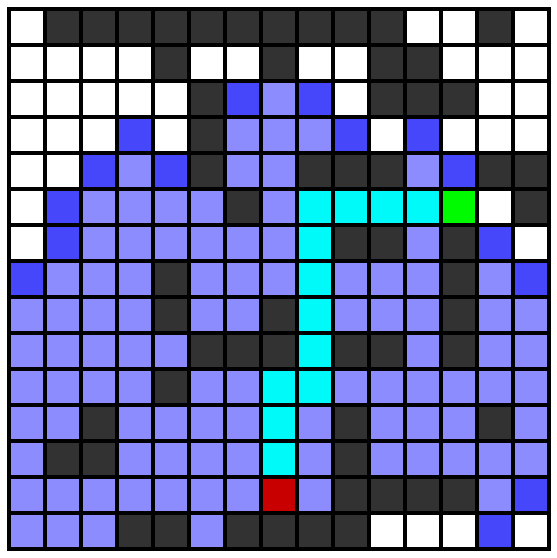

In [0]:
img.dijkstra()    # apply "Dijkstra" algorithm

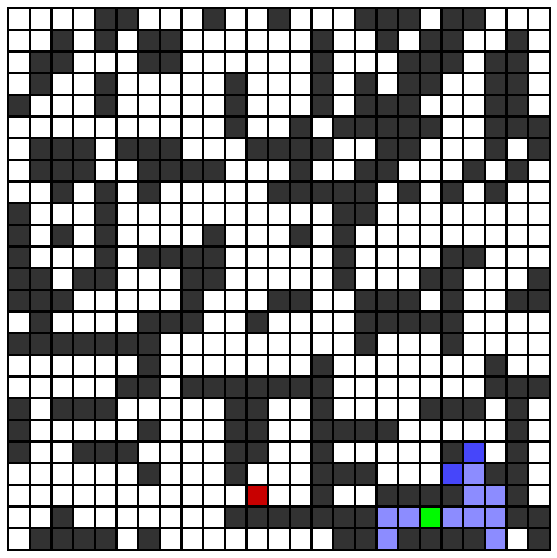

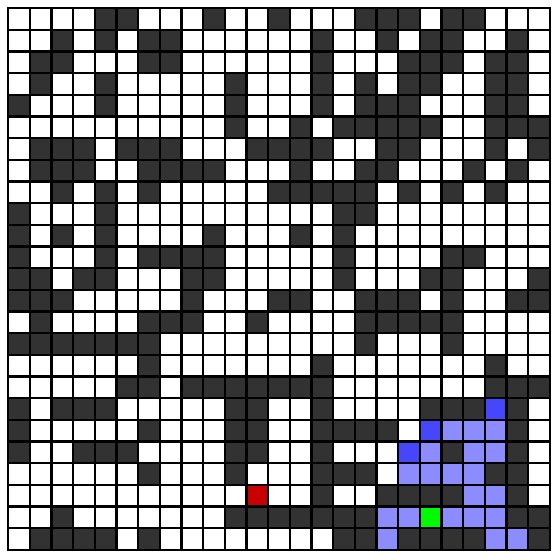

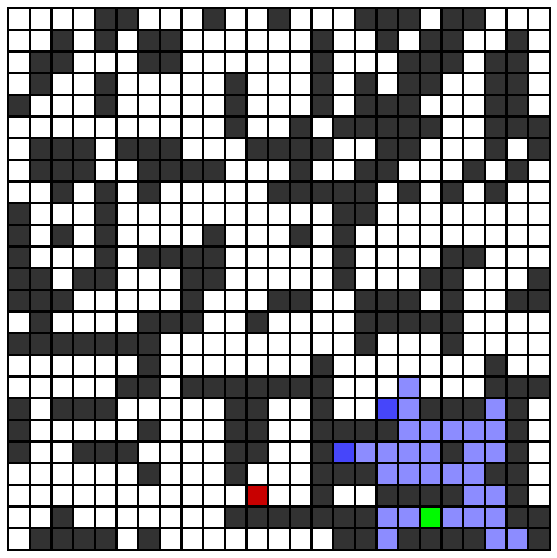

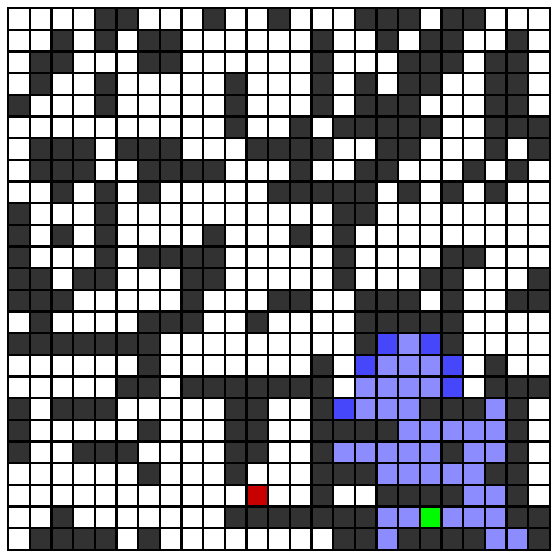

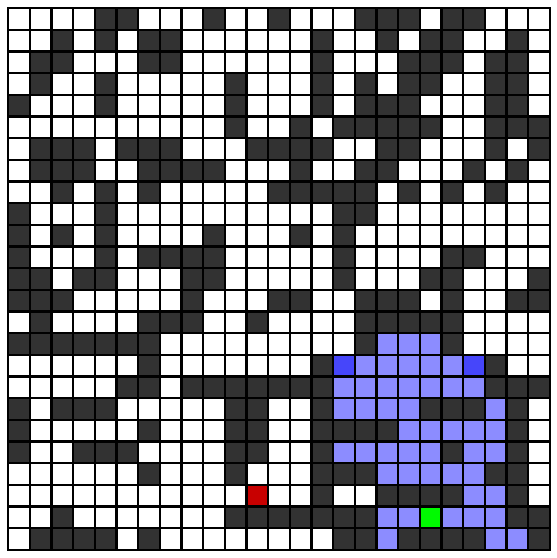

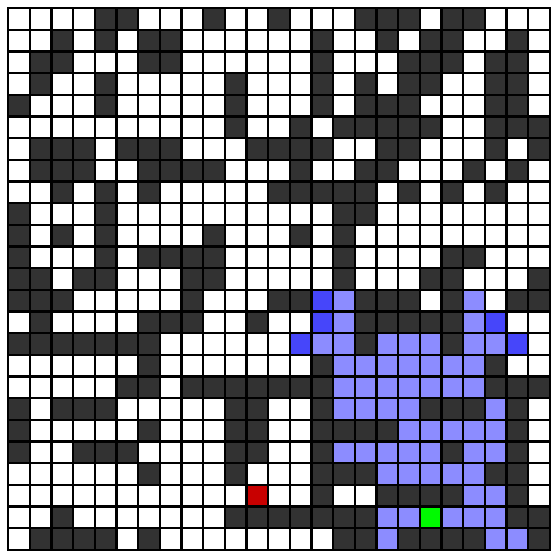

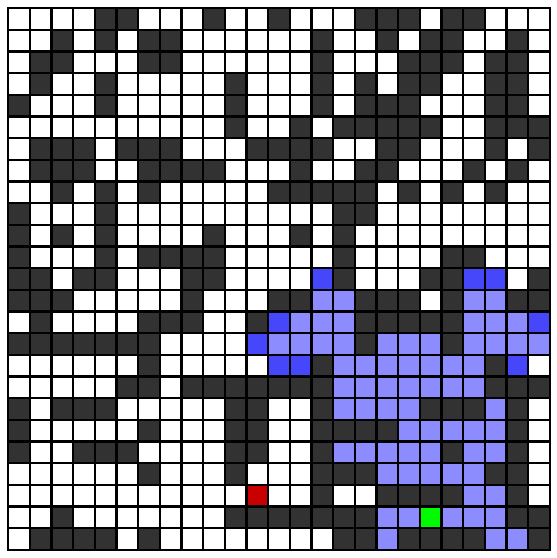

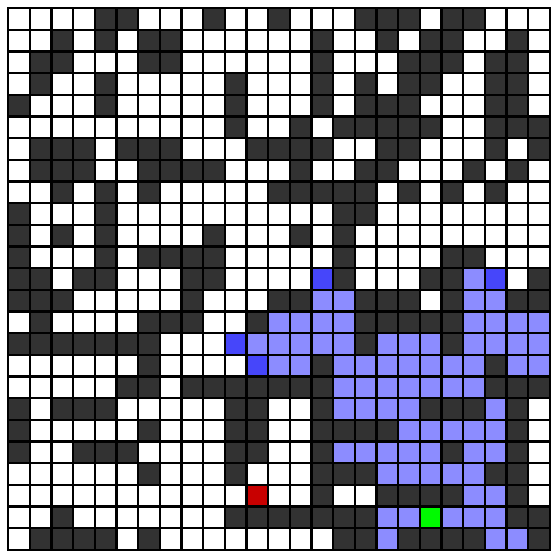

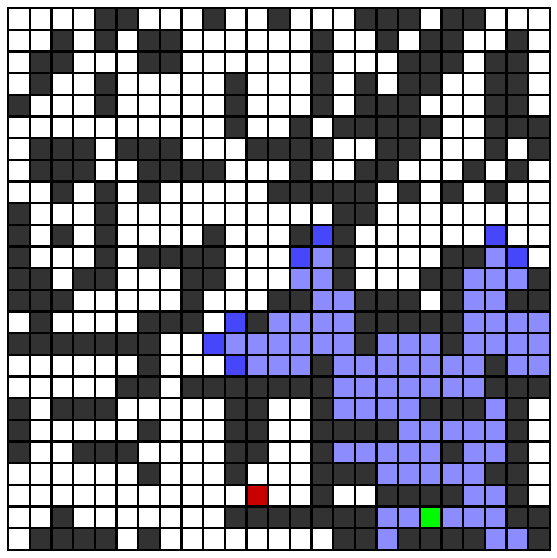

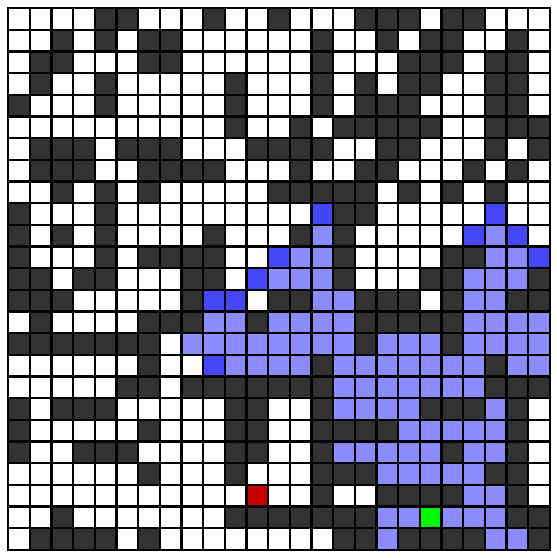

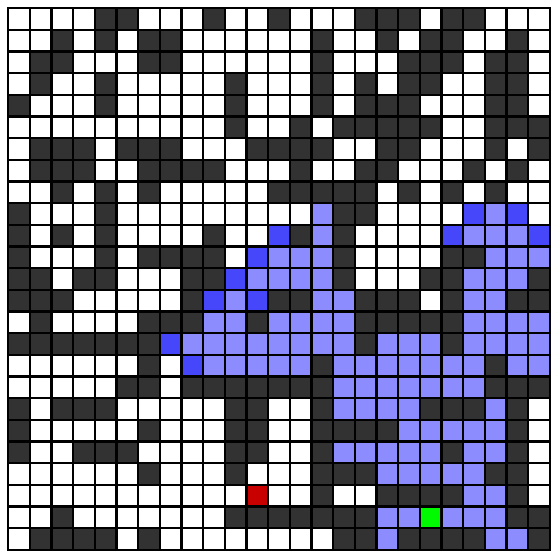

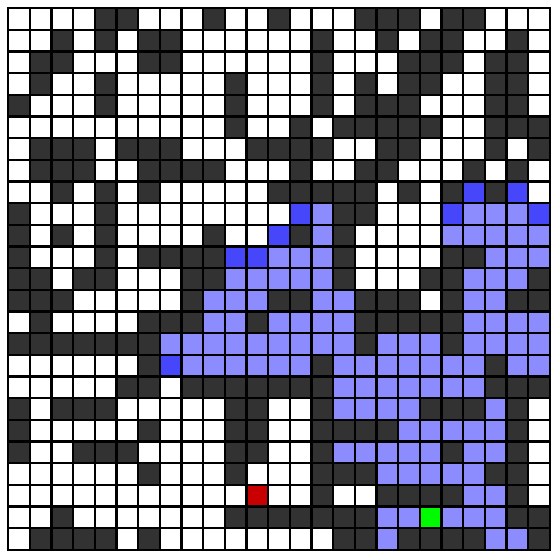

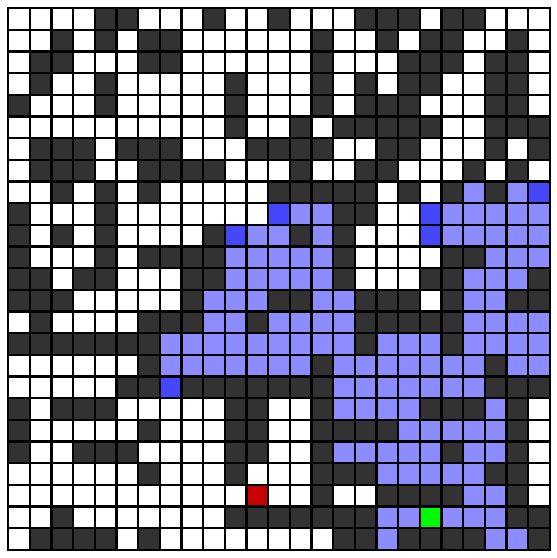

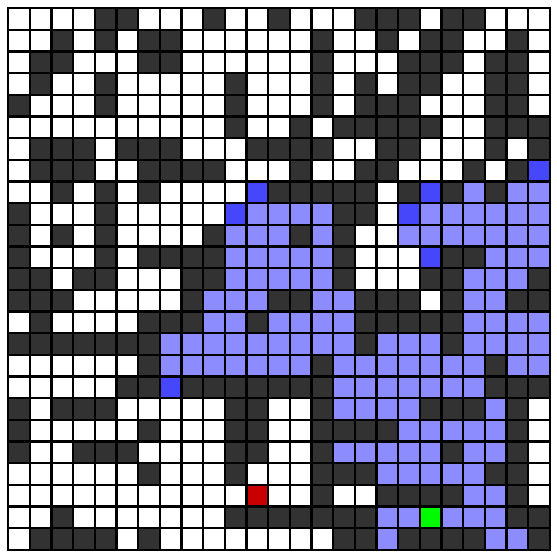

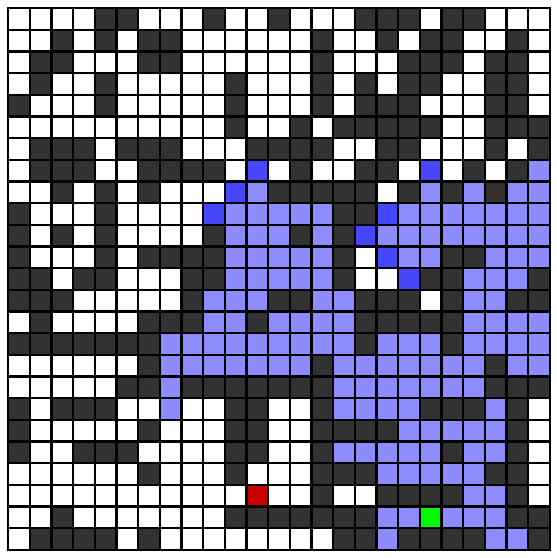

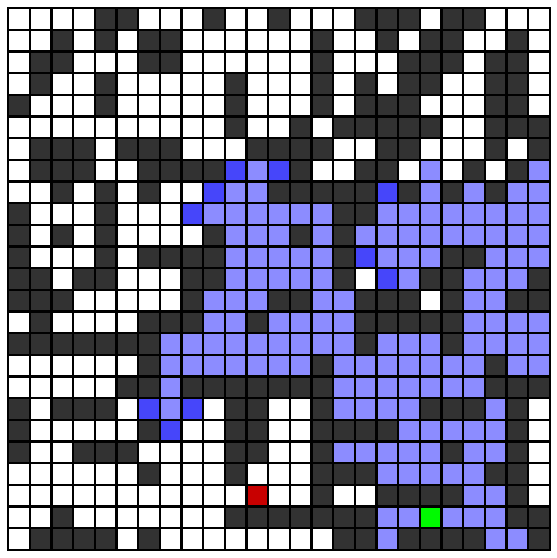

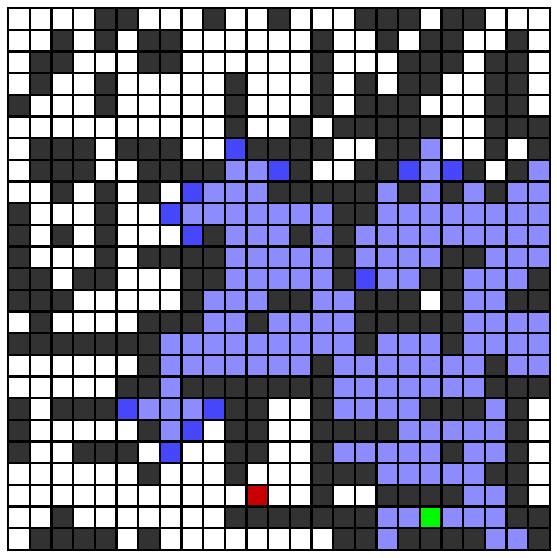

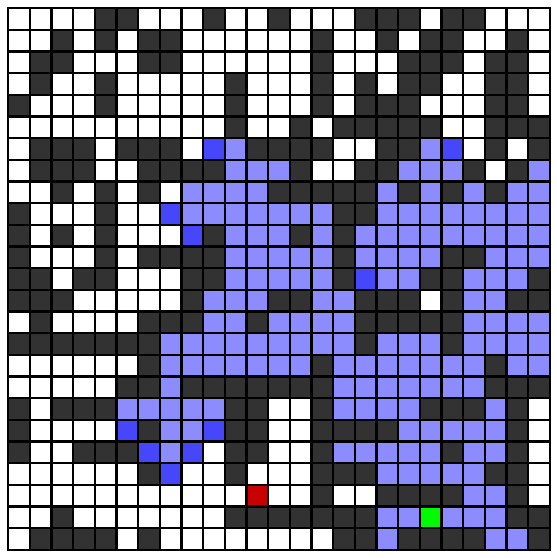

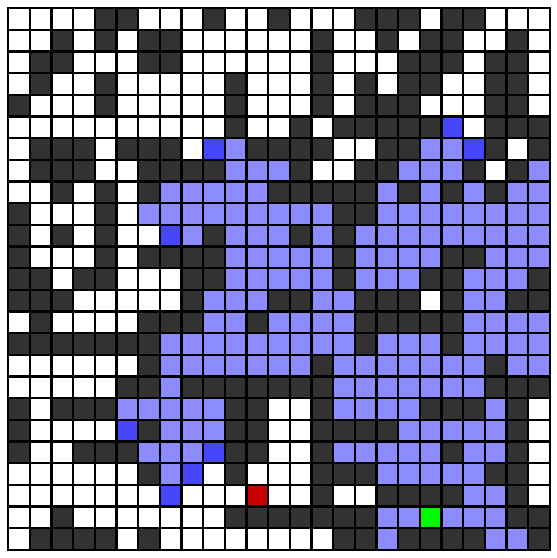

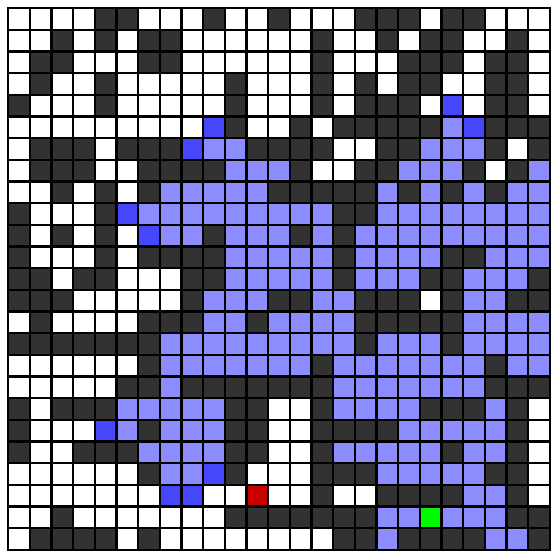

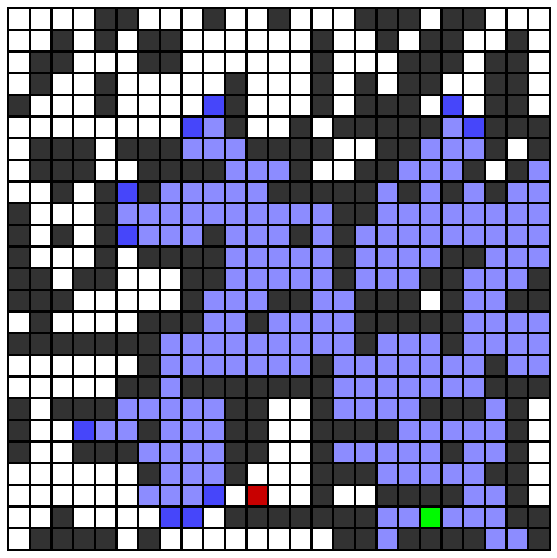

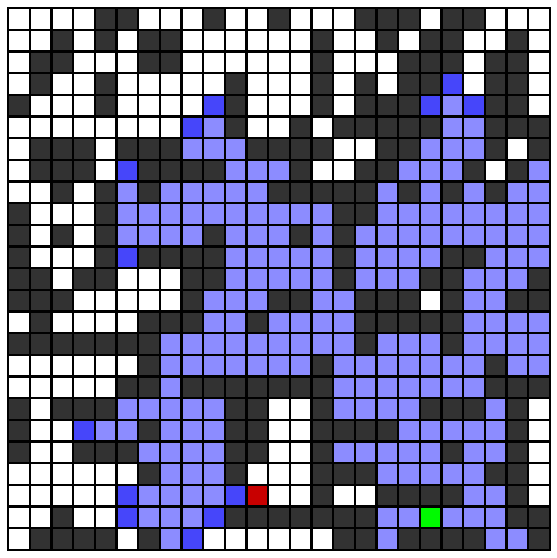

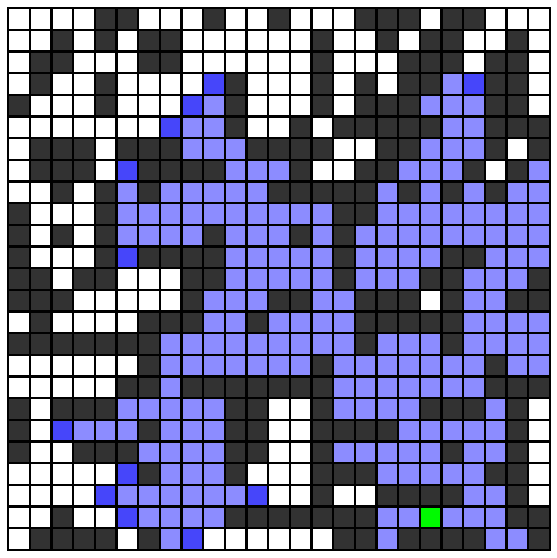

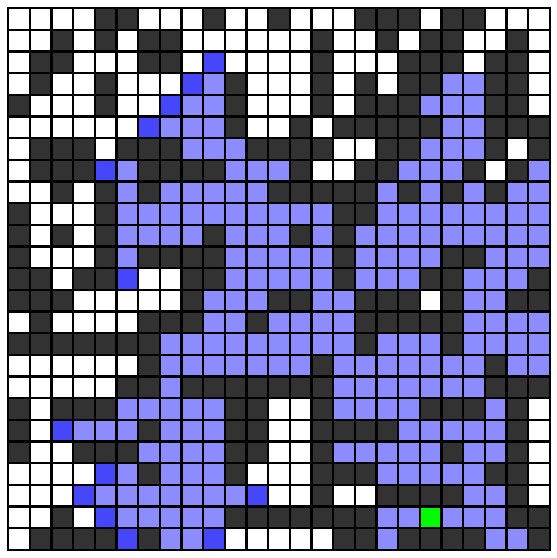

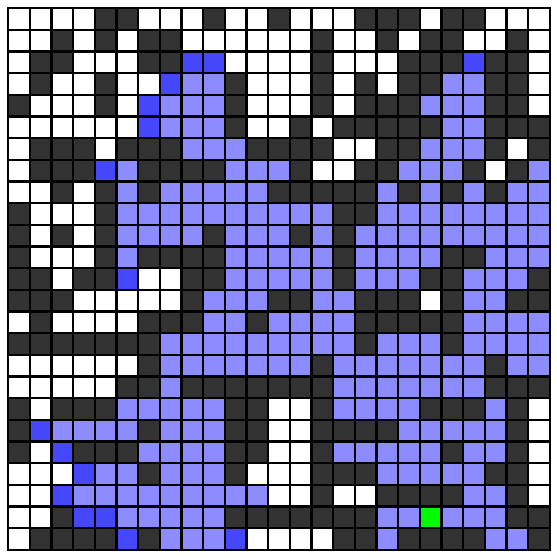

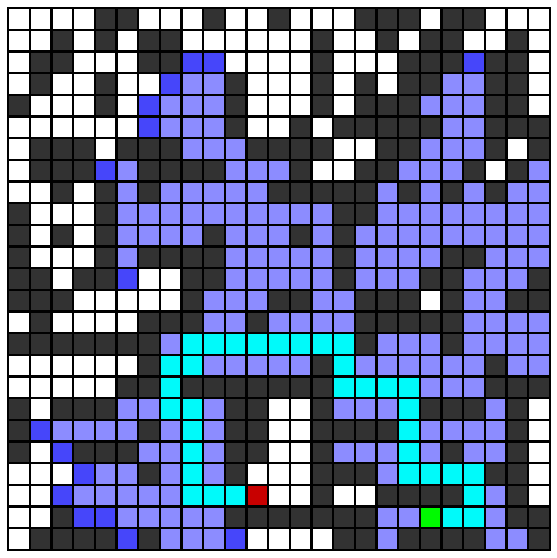

In [0]:
myMap.potential()   # apply "Potential Field" algorithm